<a href="https://colab.research.google.com/github/kiran74-ds/reinforcement_learning/blob/master/Pong_vanilla_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import cv2
from collections import deque
import matplotlib.pyplot as plt

In [2]:
env = gym.make('PongDeterministic-v0')

In [3]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [4]:
def preprocess_frame(frame):
    
    # gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # normalize_image = gray_image[20:-10, :] / 255.
    # resized_image = cv2.resize(normalize_image, (84, 84), interpolation = cv2.INTER_AREA) 
    
    bkg_color = np.array([144, 72, 17])
    img = np.mean(frame[34:-16:2,::2]-bkg_color, axis=-1)/255.
    resized_image = img
    return resized_image

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    #print(frame)
    stack_size = 4
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((80,80), dtype=np.uint8) for i in range(stack_size)], maxlen=4)
        # Because we're in a new episode, copy the same frame 4x
        for i in range(stack_size):
          stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2).transpose(2, 0, 1)
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)
        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2).transpose(2, 0, 1)
        
    return stacked_state, stacked_frames


stacked_frames = deque([np.zeros((80,80), dtype=np.uint8) for i in range(4)], maxlen=4)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQNetwork(nn.Module):
    def __init__(self, states, action_size):
        super(DQNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, (8, 8), stride=4)
        self.conv2 = nn.Conv2d(32, 64, (4, 4), stride=2)
        self.conv3 = nn.Conv2d(64, 64, (3, 3), stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, action_size)
        
    def forward(self, state):
       
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(0)

        ## hyperparameters
        self.buffer_size = 10000
        self.batch_size = 32
        self.gamma = 0.99
        self.lr = 0.0001
        self.update_every = 4
        
        # Q-Network
        self.local = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = deque(maxlen=self.buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # Initialize time step (for updating every few steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append(self.experience(state[None], action, reward, next_state[None], done))
        
        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.sample_experiences()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        # Epsilon-greedy action selection
        if random.random() > eps:
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)
          self.local.eval()
          with torch.no_grad():
            action_values = self.local(state)
          self.local.train()
          return np.argmax(action_values.cpu().data.numpy())
        else:
          return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
       # Get expected Q values from local model
        Q_expected = self.local(states).gather(1, actions)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.local(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)

In [7]:
n_episodes=3000
max_t=5000
eps_start=1.0
eps_end=0.02
eps_decay=0.995

In [8]:
agent = Agent(state_size, action_size)

Episode 100	Average Score: -20.15 	Epsilon: 0.6057704364907278


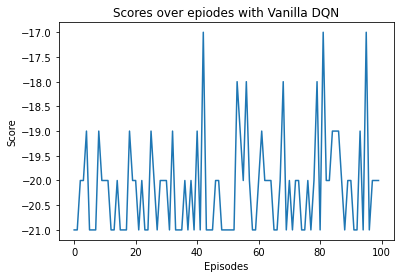

Episode 200	Average Score: -20.70 	Epsilon: 0.3669578217261671


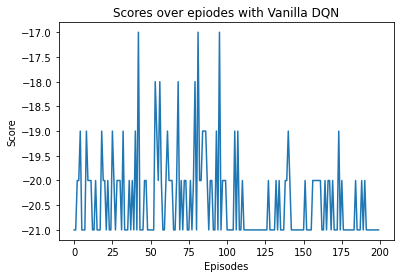

Episode 300	Average Score: -20.74 	Epsilon: 0.22229219984074702


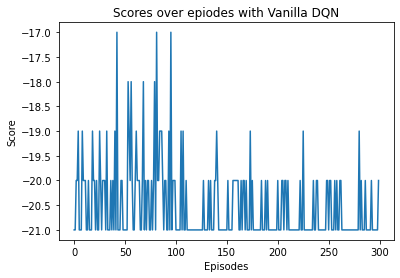

Episode 400	Average Score: -20.81 	Epsilon: 0.1346580429260134


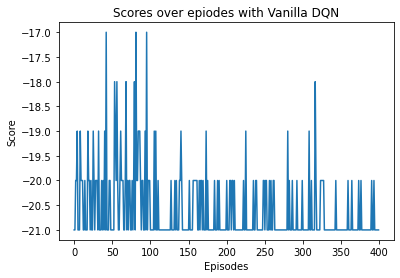

Episode 500	Average Score: -20.77 	Epsilon: 0.08157186144027828


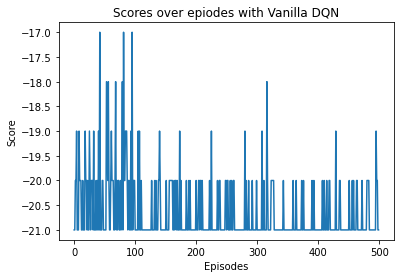

Episode 600	Average Score: -20.88 	Epsilon: 0.0494138221100385


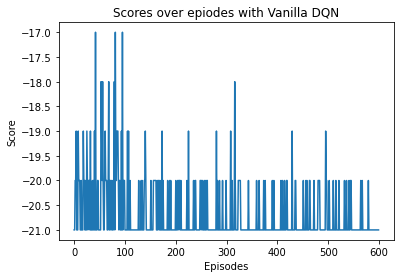

Episode 700	Average Score: -20.92 	Epsilon: 0.029933432588273214


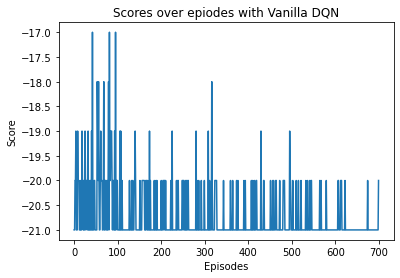

Episode 800	Average Score: -20.92 	Epsilon: 0.02


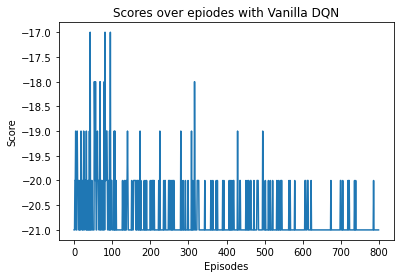

Episode 900	Average Score: -20.95 	Epsilon: 0.02


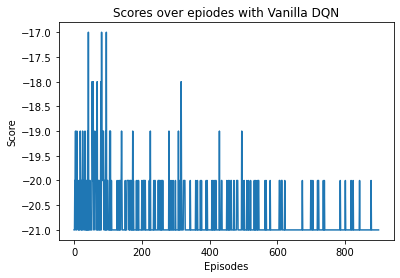

Episode 1000	Average Score: -20.93 	Epsilon: 0.02


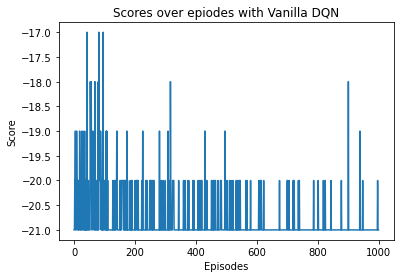

Episode 1100	Average Score: -20.96 	Epsilon: 0.02


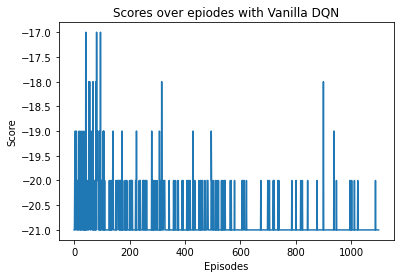

Episode 1200	Average Score: -20.93 	Epsilon: 0.02


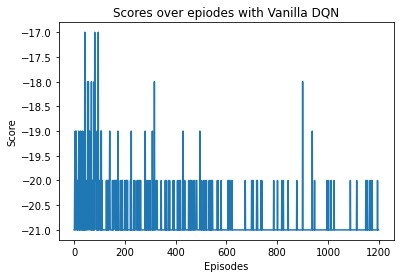

Episode 1300	Average Score: -20.96 	Epsilon: 0.02


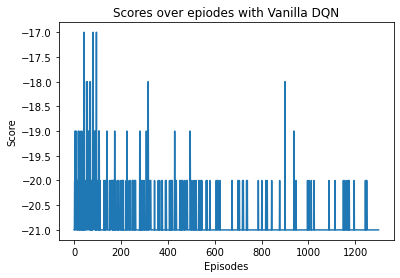

Episode 1400	Average Score: -20.93 	Epsilon: 0.02


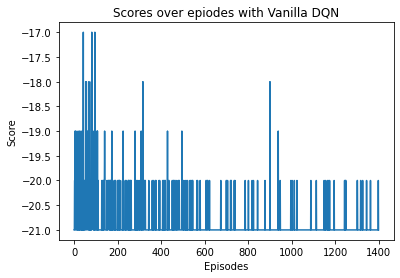

Episode 1500	Average Score: -20.97 	Epsilon: 0.02


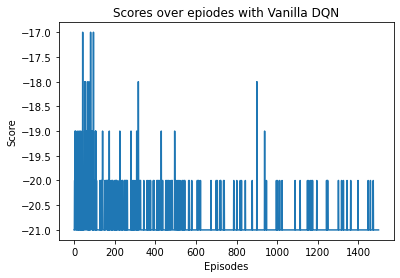

Episode 1600	Average Score: -20.95 	Epsilon: 0.02


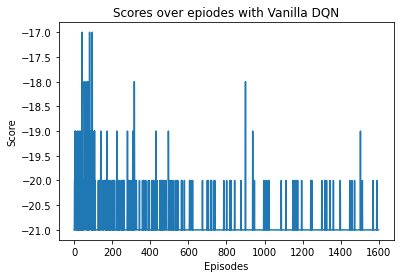

Episode 1700	Average Score: -20.94 	Epsilon: 0.02


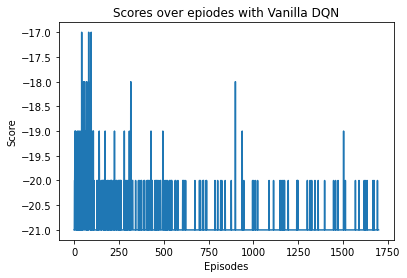

Episode 1800	Average Score: -20.91 	Epsilon: 0.02


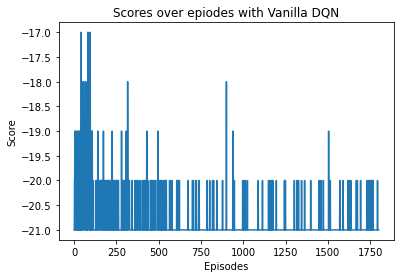

Episode 1900	Average Score: -20.90 	Epsilon: 0.02


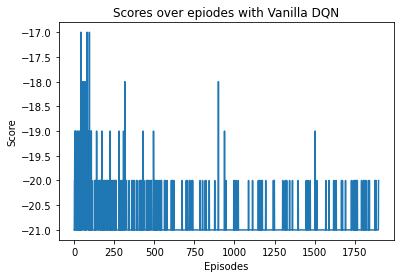

Episode 2000	Average Score: -20.96 	Epsilon: 0.02


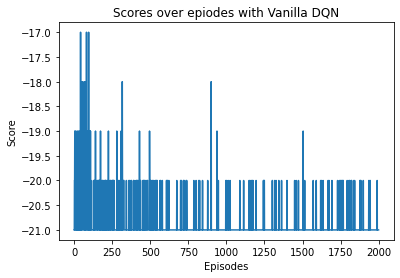

Episode 2100	Average Score: -20.92 	Epsilon: 0.02


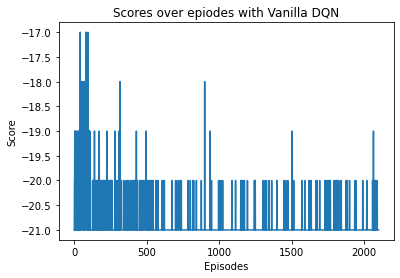

Episode 2200	Average Score: -20.96 	Epsilon: 0.02


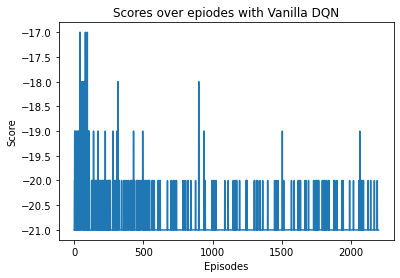

Episode 2300	Average Score: -20.92 	Epsilon: 0.02


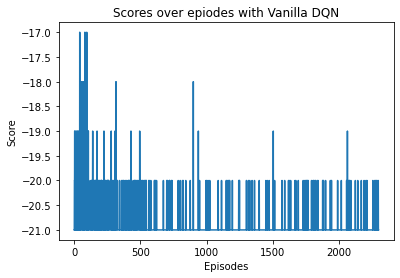

Episode 2400	Average Score: -20.92 	Epsilon: 0.02


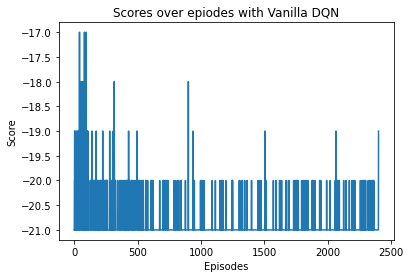

Episode 2500	Average Score: -20.93 	Epsilon: 0.02


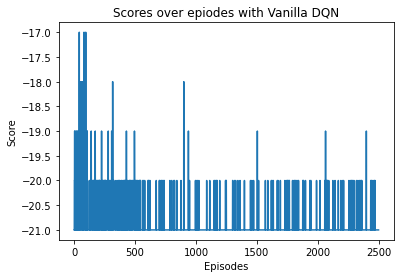

Episode 2600	Average Score: -20.92 	Epsilon: 0.02


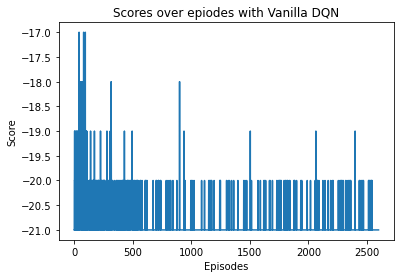

Episode 2700	Average Score: -20.93 	Epsilon: 0.02


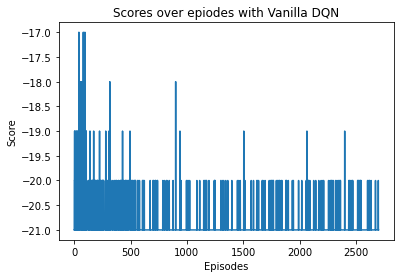

Episode 2800	Average Score: -20.94 	Epsilon: 0.02


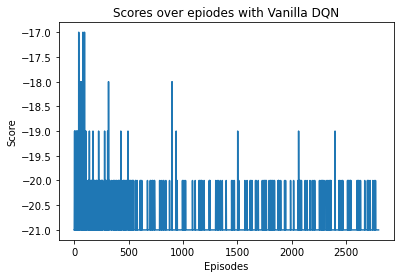

Episode 2900	Average Score: -20.98 	Epsilon: 0.02


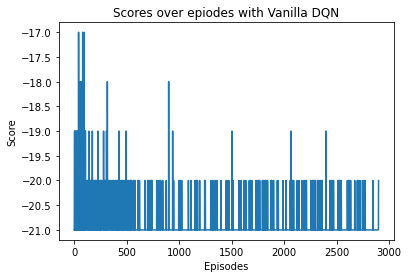

Episode 3000	Average Score: -20.96 	Epsilon: 0.02


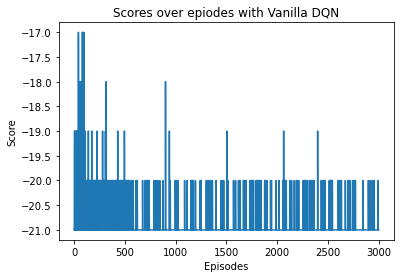

In [9]:
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start
stack_size = 4
stacked_frames  =  deque([np.zeros((80,80), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)    
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    state, frames = stack_frames(stacked_frames, state, True)
    # plt.imshow(state[3,:,:])
    # plt.show()
    score = 0
    for i in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, _  = env.step(action)
        next_state, frames = stack_frames(frames, next_state, False)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tReward {} \tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode,score,np.mean(scores_window), eps), end="")
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f} \tEpsilon: {}'.format(i_episode, np.mean(scores_window), eps))
      import matplotlib.pyplot as plt
      %matplotlib inline
      plt.plot(scores)
      plt.title('Scores over epiodes with Vanilla DQN')
      plt.xlabel('Episodes')
      plt.ylabel('Score')
      plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(scores)
plt.title('Scores over epiodes')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()